In [1]:
import os
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import read_csv, concat
sns.set_theme(context='notebook', style='white', font_scale=1.33)

import numpy as np
from os.path import dirname
from pandas import read_csv
import pandas as pd
from numba import njit
from tqdm import tqdm
import json
from os.path import exists


#### get samples from stan results

In [14]:
stan_models = ['m1','m2', 'm3', 'm4', 'm5', 'm6']
stan_versions = ['a','b']
sessions = [1, 2, 3]

all_samples = []
# all_summ = []

for stan_model in stan_models:
    for stan_version in stan_versions:
        for session in sessions:
      
            path_to_file = os.path.join('stan_results', 
                                        f'{stan_model}{version}_s{session}_summary.tsv')

            if exists(path_to_file):

                df = read_csv(path_to_file, sep='\t')
                df['model'] = stan_model
                df['session'] = session
                df['version'] = stan_version

                all_samples.append(df)
        #         all_summ.append(StanFit)

all_samples = concat(all_samples)
# all_summ = concat(all_summ)


In [15]:
all_data = []
for stan_model in stan_models:
    for stan_version in stan_versions:
        for session in sessions:
            path_to_file = os.path.join('stan_results', 'ppc',
                            f'{stan_model}{stan_version}_s{session}_ppc.tsv')
            if exists(path_to_file):
                df = read_csv(path_to_file, sep='\t')
                df['model'] = stan_model
                df['version'] = stan_version
                all_data.append(df)
        
        
all_data = concat(all_data)


In [7]:
#general fit
# all_samples.groupby('model').max()['R_hat']#R_hat.min()
all_samples[all_samples.R_hat>1.02].groupby('model').count()['R_hat']

model
m1    179
m3      3
m4      2
m5     43
m6      1
Name: R_hat, dtype: int64

In [ ]:
all_data

In [12]:
all_samples.query('model=="m5" and R_hat>1.02')['name'].reg




176     theta_pr[2,56]
582             L[5,2]
120     theta_pr[2,13]
121     theta_pr[2,14]
123     theta_pr[2,16]
143     theta_pr[2,36]
148     theta_pr[2,41]
149     theta_pr[2,42]
157     theta_pr[2,50]
158     theta_pr[2,51]
178     theta_pr[2,71]
179     theta_pr[2,72]
184     theta_pr[2,77]
186     theta_pr[2,79]
204     theta_pr[2,97]
507             L[3,2]
517             L[5,2]
138     theta_pr[2,29]
155     theta_pr[2,46]
164     theta_pr[2,55]
181     theta_pr[2,72]
208     theta_pr[2,99]
517             L[3,2]
522             L[4,2]
524             L[4,4]
527             L[5,2]
135     theta_pr[2,17]
136     theta_pr[2,18]
145     theta_pr[2,27]
154     theta_pr[2,36]
159     theta_pr[2,41]
162     theta_pr[2,44]
164     theta_pr[2,46]
167     theta_pr[2,49]
185     theta_pr[2,67]
190     theta_pr[2,72]
197     theta_pr[2,79]
199     theta_pr[2,81]
202     theta_pr[2,84]
225    theta_pr[2,107]
227    theta_pr[2,109]
462             L[4,2]
464             L[4,4]
Name: name,

In [4]:
samples = pd.DataFrame(columns = ['subject','Mean','model','session', 'param'])

In [5]:
cols = ['name','Mean','model','session']
samples = pd.concat([all_samples[all_samples.name.str.match('^beta\[')==True][cols],
          all_samples[all_samples.name.str.match('^beta_P')==True][cols],
          all_samples[all_samples.name.str.match('^beta_GO')==True][cols],
          all_samples[all_samples.name.str.match('^eta\[')==True][cols],
          all_samples[all_samples.name.str.match('^eta_cong')==True][cols],
          all_samples[all_samples.name.str.match('^eta_incong')==True][cols],
          all_samples[all_samples.name.str.match('^eta_gain')==True][cols],
          all_samples[all_samples.name.str.match('^eta_loss')==True][cols]],  
                   )


In [6]:
samples['subj'] = samples.name.str.extract(r'([0-9]{1,3})')
samples['param'] = samples.name.str.extract(r'([b]?eta_?[A-Za-z]{0,6})')
samples = samples[['Mean','model','session','subj','param']]

In [7]:
samples.head()

,Mean,model,session,subj,param
339,26109.4,m1,1,1,beta
340,27612.7,m1,1,2,beta
341,28724.1,m1,1,3,beta
342,30379.9,m1,1,4,beta
343,30770.0,m1,1,5,beta


In [8]:
samples.param.unique()

array(['beta', 'beta_P', 'beta_GO', 'eta', 'eta_cong', 'eta_incong',
       'eta_gain', 'eta_loss'], dtype=object)

In [9]:
samples_pivot = samples.pivot_table(index=['model','session','subj'], 
              columns='param', values='Mean').reset_index()

##### comapre model 2 and model 3

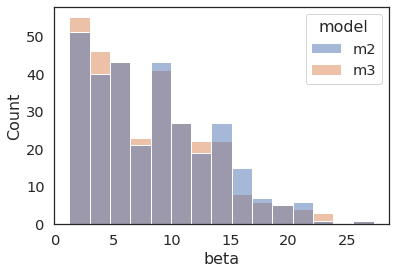

In [75]:
p0 = sns.histplot(data=samples_pivot[samples_pivot.model.isin(['m2','m3'])],
                 x='beta',
                  hue='model')

r=  -0.216


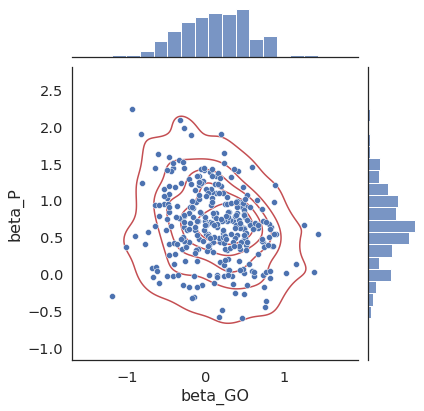

In [73]:

p1 = sns.jointplot(data=samples_pivot[samples_pivot.model=='m3'], 
              x="beta_GO", 
              y="beta_P")
              #kind="kde")
p1.plot_joint(sns.kdeplot, color="r", zorder=0, levels=6)
# p1.plot_marginals(sns.rugplot, color="r", height=-.15, clip_on=False)

_, _, r_value, p_value, _ = sp.stats.linregress(samples_pivot[samples_pivot.model=='m3'].beta_P,
                                              samples_pivot[samples_pivot.model=='m3'].beta_GO)

print('r= ',np.round(r_value,3))




In [77]:
m2_beta_p = samples_pivot[samples_pivot.model=='m2'][['beta_P','session','subj']]
m3_beta_p = samples_pivot[samples_pivot.model=='m3'][['beta_P','session','subj']]
m2_beta_p
gb_beta_p = pd.merge(m2_beta_p, m3_beta_p, 
         on=['session','subj'], suffixes=('_m2', '_m3'))


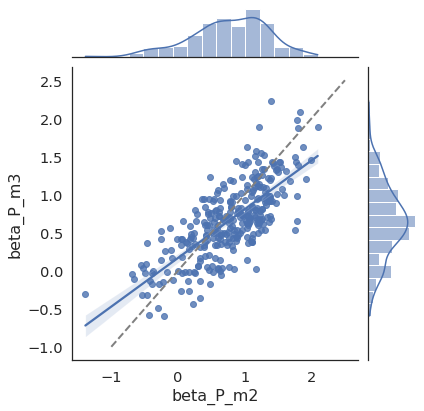

In [78]:
p3 = sns.jointplot(x='beta_P_m2', 
                   y='beta_P_m3', 
                   data=gb_beta_p,
                   kind="reg")

p3.ax_joint.plot([-1, 2.5], [-1, 2.5], 
                 color='grey', 
                 linestyle='--',
                 linewidth = 2)



In [79]:
_, _, r_value, p_value, _ = sp.stats.linregress(gb_beta_p.beta_P_m2,
                                              gb_beta_p.beta_P_m3)

print('r= ',np.round(r_value,3))
print('p= ',p_value)



r^2=  0.74
p=  2.7580381921297643e-54


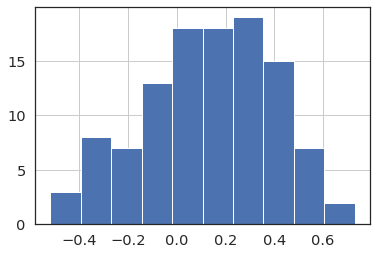

In [28]:
## get subejecst with high b-go

mean_beta_go = samples_pivot[samples_pivot.model=='m3'].groupby('subj').mean()['beta_GO'].reset_index()

mean_beta_go.beta_GO.hist()
above_med_go_subjects = mean_beta_go[mean_beta_go.beta_GO>mean_beta_go.beta_GO.median()].subj.tolist()


with open('analysis_arrays/above_med_go_subjects.npy', 'wb') as f:
    np.save(f, np.array(above_med_go_subjects))
    


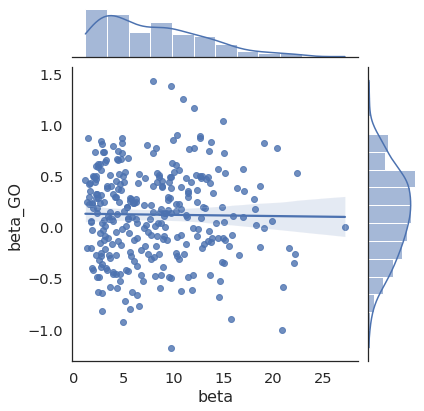

In [78]:
p3_1 = sns.jointplot(x='beta', 
                   y='beta_GO', 
                   data=samples_pivot[samples_pivot.model=='m3'],
                   kind="reg")



In [82]:
def inv_logit(x):
    return 1. / (1 + np.exp(-x))

inv_logit(0.2) - .5

0.04983399731247795

In [20]:
########### assym eta

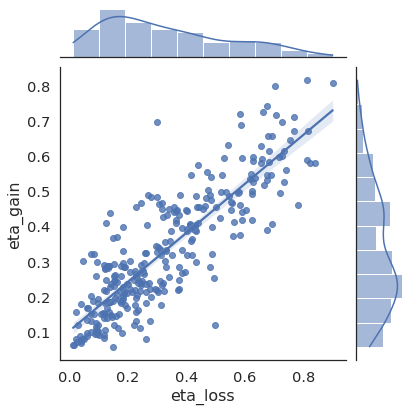

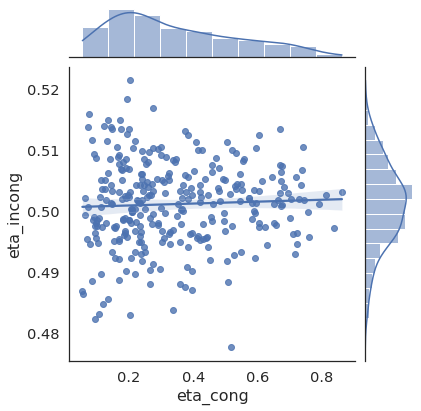

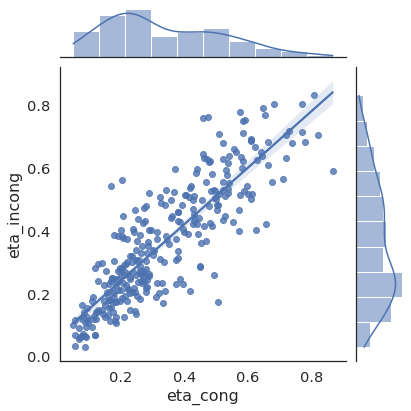

In [10]:
p4 = sns.jointplot(x='eta_loss', 
                   y='eta_gain', 
                   data=samples_pivot[samples_pivot.model=='m4'],
                   kind="reg")

p4 = sns.jointplot(x='eta_cong', 
                   y='eta_incong', 
                   data=samples_pivot[samples_pivot.model=='m5'],
                   kind="reg")


p4 = sns.jointplot(x='eta_cong', 
                   y='eta_incong', 
                   data=samples_pivot[samples_pivot.model=='m6'],
                   kind="reg")

In [54]:
# p5 = sns.histplot(x='param',
#         data=samples[samples.param.isin(['eta_loss','eta_gain'])][['param','Mean']])

# # samples
# samples[samples.param.isin(['eta_loss','eta_gain'])][['param','Mean']]

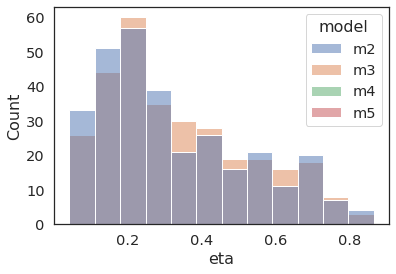

In [91]:
p5 = sns.histplot(x='eta', hue='model',
                   data=samples_pivot[samples_pivot.model!='m1'])
plt.show()
